# Expériences/Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from base import *
from mltools import *

## PARTIE 1 : Régression linéaire

In [2]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

In [3]:
# generate data for linear regression
datax, datay = make_regression(n_samples=1000, n_features=1, noise=5.0, random_state=42)

In [4]:
# Initialize model
linear = Linear(datax.shape[-1], datay.shape[-1])
mse_loss = MSELoss()

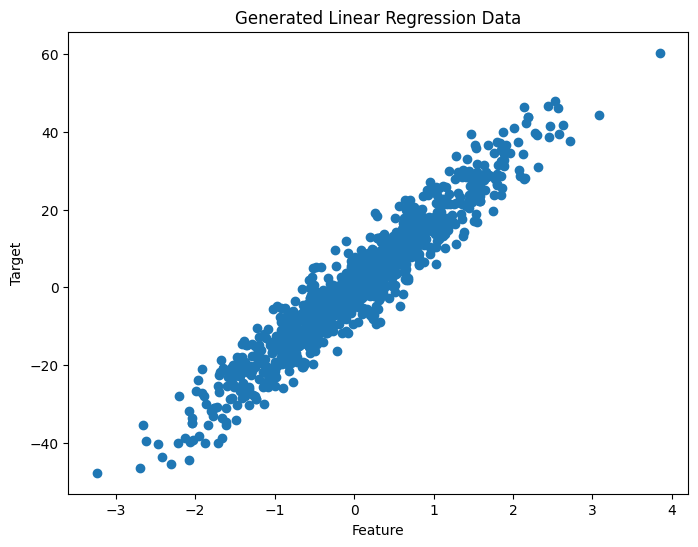

In [5]:
# visualise the data
plt.figure(figsize=(8, 6))
plt.scatter(datax, datay)
plt.title("Generated Linear Regression Data")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

In [6]:
# Parameters
n_iterations = 100
gradient_step = 0.0001

In [7]:
# Descent gradient
loss_history = np.zeros(n_iterations)

for i in range(n_iterations):
    # Forward pass
    yhat = linear.forward(datax)
    loss = mse_loss.forward(datay, yhat)
    loss_history[i] = loss.mean()
    
    # Backward pass
    delta = mse_loss.backward(datay, yhat)
    
    linear.zero_grad()
    linear.backward_update_gradient(datax, delta)
    linear.update_parameters(gradient_step)

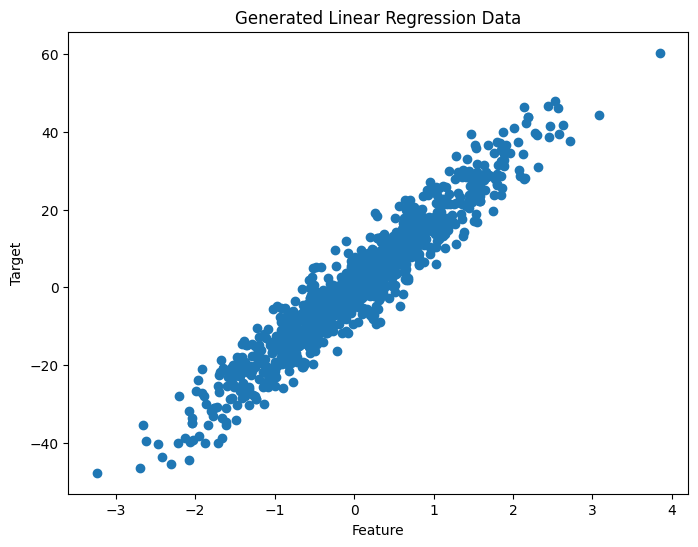

In [8]:
# Après apprentissage
plt.figure(figsize=(8, 6))
plt.scatter(datax, datay)
plt.title("Generated Linear Regression Data")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

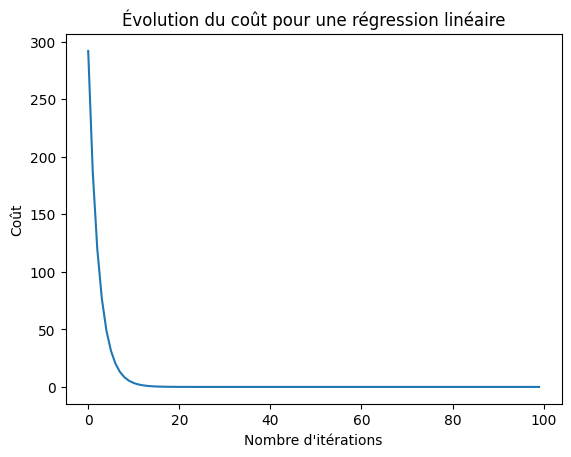

In [9]:
plt.plot(range(n_iterations), loss_history)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Coût")
plt.title("Évolution du coût pour une régression linéaire")
plt.show()

## PARTIE 2 : Réseau à 2 couches avec tanh entre les 2 couches et sigmoide à la sortie

In [10]:
datax, datay = gen_arti(nbex=10000, data_type=1)

In [11]:
# Conversion des labels de y : {-1, 1} --> {0, 1}
datay = np.where(datay == -1, 0, 1)

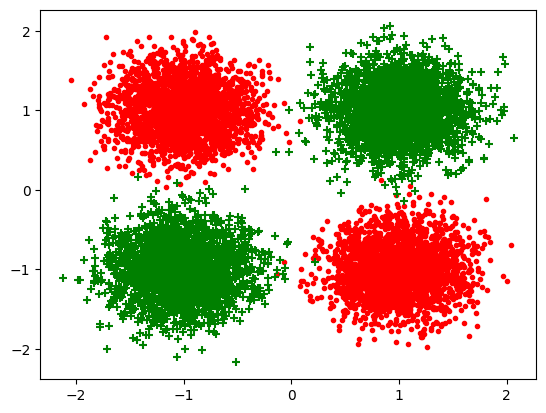

In [12]:
plot_data(datax, datay)

In [13]:
# Initialize the layers
hidden_dim = 16

layer1 = Linear(datax.shape[-1], hidden_dim)
tanh = TanH()
layer2 = Linear(hidden_dim, datay.shape[-1])
sigmoid = Sigmoide()
loss_fn = MSELoss()

In [14]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001

In [15]:
loss_history = np.zeros(num_epochs)
accuracy_history = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Forward pass
    output1 = layer1.forward(datax)
    output2 = tanh.forward(output1)
    output3 = layer2.forward(output2)
    yhat = sigmoid.forward(output3)
    loss = loss_fn.forward(datay, yhat)

    # Backward pass
    delta3 = loss_fn.backward(datay, yhat)
    delta2 = sigmoid.backward_delta(output3, delta3)
    delta1 = layer2.backward_delta(output2, delta2)
    layer2.backward_update_gradient(output2, delta2)
    delta0 = tanh.backward_delta(output1, delta1)
    layer1.backward_update_gradient(datax, delta0)

    # Update parameters
    layer1.update_parameters(learning_rate)
    layer2.update_parameters(learning_rate)

    loss_history[epoch] = loss.mean()
    accuracy_history[epoch] = accuracy_bin(yhat, datay)

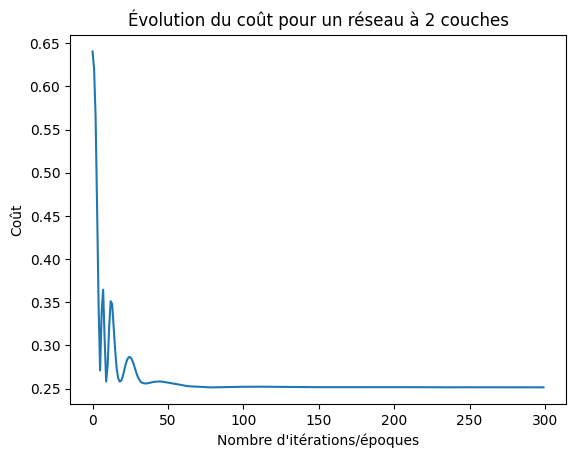

In [16]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour un réseau à 2 couches")
plt.show()

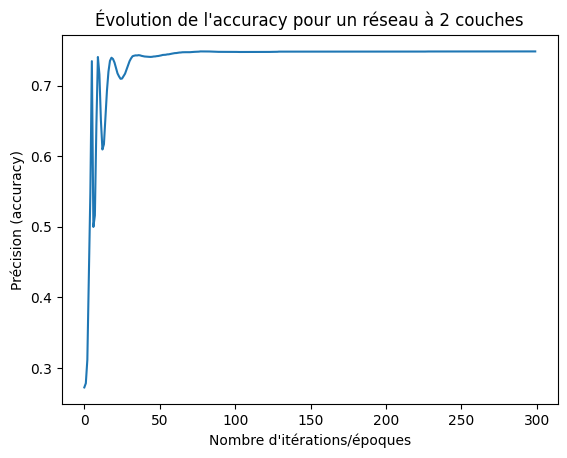

In [17]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision (accuracy)")
plt.title("Évolution de l'accuracy pour un réseau à 2 couches")
plt.show()

## PARTIE 3 : Utilisation des classes Sequentiel, Optim

In [18]:
datax, datay = gen_arti(nbex=10000, data_type=1)

In [19]:
# Conversion des labels de y : {-1, 1} --> {0, 1}
datay = np.where(datay == -1, 0, 1)

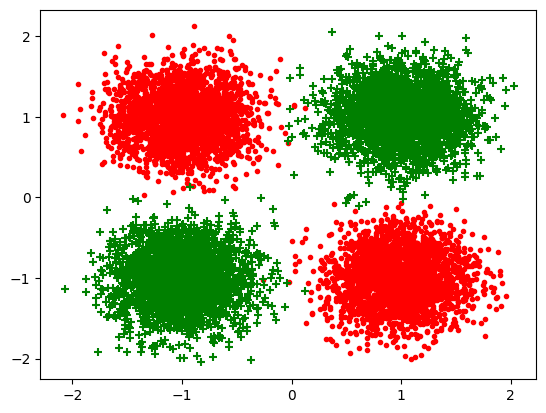

In [20]:
plot_data(datax, datay)

In [21]:
# Initialize the network
hidden_dim = 16

net = Sequentiel()
net.add_module(Linear(datax.shape[-1], hidden_dim))
net.add_module(TanH())
net.add_module(Linear(hidden_dim, datay.shape[-1]))
net.add_module(Sigmoide())

loss_fn = MSELoss()

In [22]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001
batch_size = 25

In [23]:
opt = Optim(net, loss_fn, learning_rate)

In [24]:
loss_history = []
accuracy_history = []
for epoch in range(num_epochs):
    loss, acc = opt.step(datax, datay)
    loss_history.append(loss)
    accuracy_history.append(acc)

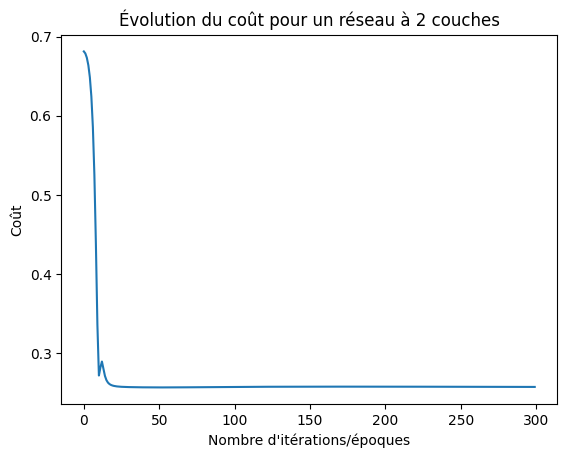

In [25]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour un réseau à 2 couches")
plt.show()

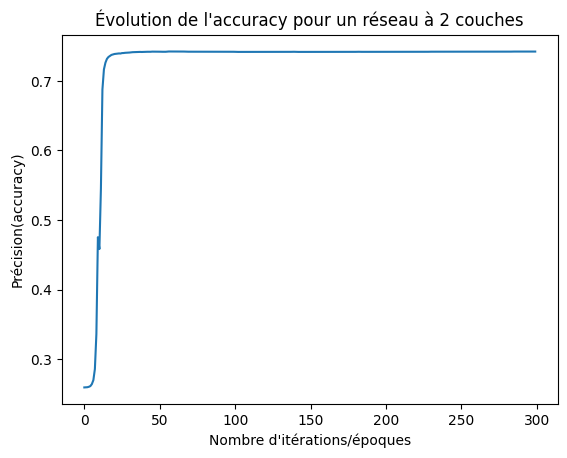

In [26]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision(accuracy)")
plt.title("Évolution de l'accuracy pour un réseau à 2 couches")
plt.show()

## PARTIE 3 : Test de la fonction SGD (par batch)

In [27]:
datax, datay = gen_arti(nbex=10000, data_type=1)

In [28]:
# Conversion des labels de y : {-1, 1} --> {0, 1}
datay = np.where(datay == -1, 0, 1)

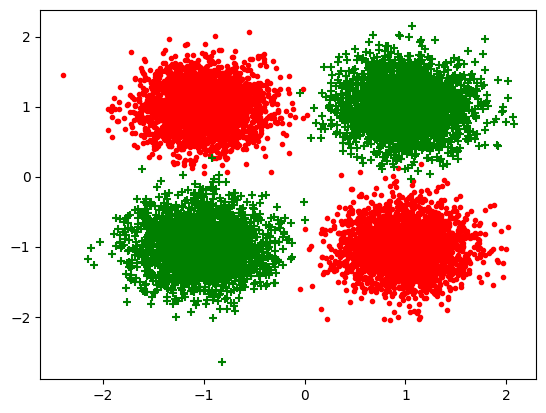

In [29]:
plot_data(datax, datay)

In [30]:
# Initialize the network
hidden_dim = 16

net = Sequentiel()
net.add_module(Linear(datax.shape[-1], hidden_dim))
net.add_module(TanH())
net.add_module(Linear(hidden_dim, datay.shape[-1]))
net.add_module(Sigmoide())

loss_fn = MSELoss()

In [31]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001
batch_size = 250

In [32]:
opt = Optim(net, loss_fn, learning_rate)

In [33]:
loss_history, accuracy_history = SGD(net, loss_fn, datax, datay, batch_size, num_epochs, learning_rate)

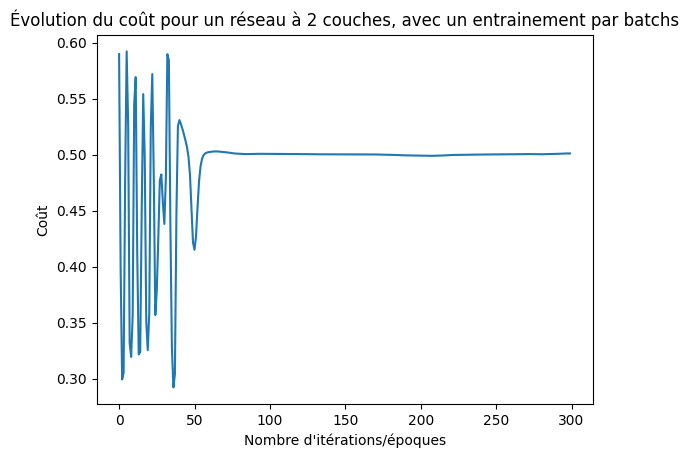

In [34]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour un réseau à 2 couches, avec un entrainement par batchs")
plt.show()

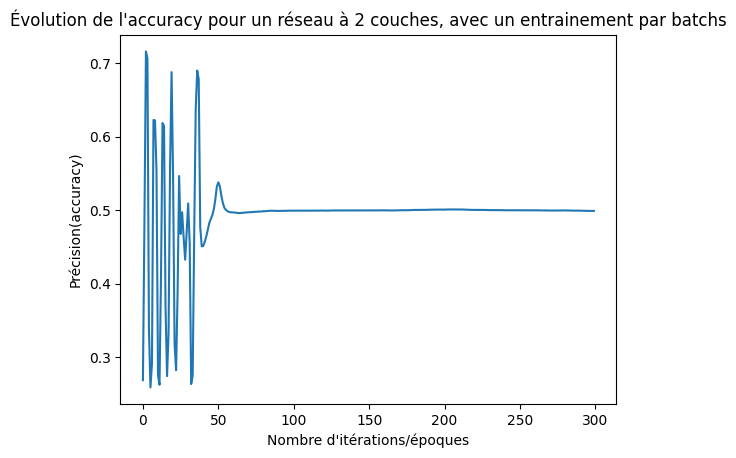

In [35]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision(accuracy)")
plt.title("Évolution de l'accuracy pour un réseau à 2 couches, avec un entrainement par batchs")
plt.show()

## PARTIE 4 : Test multi-classe sur le jeu de données des chiffres manuscrits (résultats étranges cf. Rapport)

In [36]:
import pickle as pkl

In [37]:
data = pkl.load(open("usps.pkl",'rb'))
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
X_train = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
X_test = np.array(data["X_test"],dtype=float)
Y_train = data["Y_train"]
Y_test = data["Y_test"]

In [38]:
# One-hot encoding 
num_classes = len(np.unique(Y_train))
Y_train = one_hot_encode(Y_train, num_classes)
Y_test = one_hot_encode(Y_test, num_classes)

In [39]:
# Initialize the network
hidden_dim1 = 128
hidden_dim2 = 64

net = Sequentiel()
net.add_module(Linear(X_train.shape[-1], hidden_dim1))
net.add_module(TanH())
net.add_module(Linear(hidden_dim1, hidden_dim2))
net.add_module(TanH())
net.add_module(Linear(hidden_dim2, Y_train.shape[-1]))

loss_fn = CELogSoftmax()

In [40]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001

In [41]:
opt = Optim(net, loss_fn, learning_rate)

In [42]:
loss_history = []
accuracy_history = []
for i in range(num_epochs):
    loss, acc = opt.step(X_train, Y_train)
    loss_history.append(np.mean(loss))
    accuracy_history.append(acc)

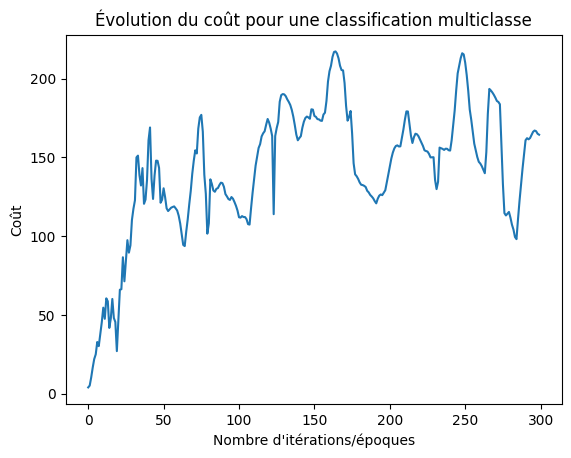

In [43]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour une classification multiclasse")
plt.show()

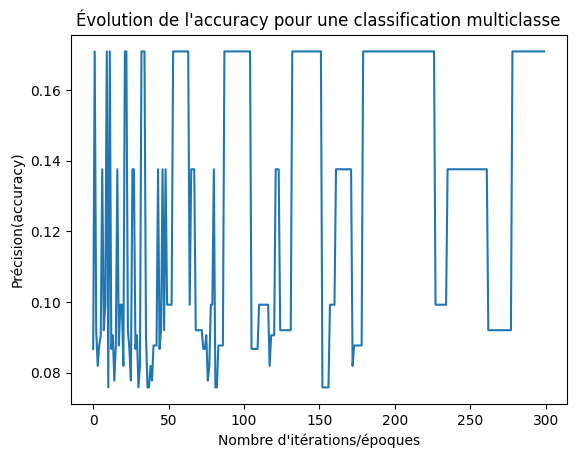

In [44]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision(accuracy)")
plt.title("Évolution de l'accuracy pour une classification multiclasse")
plt.show()

## PARTIE 4 : Test multi-classe sur le jeu de données Iris

In [45]:
from sklearn.datasets import load_iris

In [46]:
# Téléchargement et préparation des données MNIST
iris = load_iris()
X = iris.data
y = iris.target

In [47]:
# One-hot encoding 
num_classes = len(np.unique(y))
Y = one_hot_encode(y, num_classes)

In [48]:
# Initialize the network
hidden_dim = 50

net = Sequentiel()
net.add_module(Linear(X.shape[-1], hidden_dim))
net.add_module(TanH())
net.add_module(Linear(hidden_dim, Y.shape[-1]))

loss_fn = CELogSoftmax()

In [49]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001

In [50]:
opt = Optim(net, loss_fn, learning_rate)

In [51]:
loss_history = []
accuracy_history = []
for i in range(num_epochs):
    loss, acc = opt.step(X, Y)
    loss_history.append(loss)
    accuracy_history.append(acc)

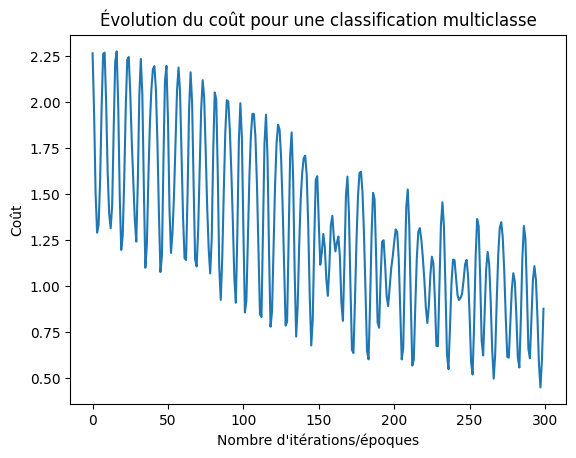

In [52]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution du coût pour une classification multiclasse")
plt.show()

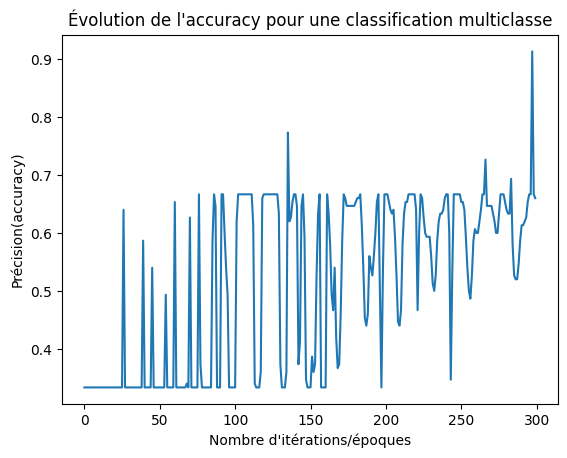

In [53]:
plt.plot(range(num_epochs), accuracy_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Précision(accuracy)")
plt.title("Évolution de l'accuracy pour une classification multiclasse")
plt.show()

## PARTIE 5 : Étude des performances en débruitage pour de la classification

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [55]:
# Charger le dataset Iris
iris = load_iris()
X = iris.data
y = iris.target

In [56]:
# One-hot encoding 
num_classes = len(np.unique(y))
Y = one_hot_encode(y, num_classes)

In [57]:
# Normalisation min-max
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X = (X - X_min) / (X_max - X_min)

In [58]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [59]:
# Ajouter du bruit gaussien aux données d'entraînement et de test
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [60]:
hidden_dim = 50
net = Sequentiel()

# Encodeur
net.add_module(Linear(X_train_noisy.shape[-1], hidden_dim))
net.add_module(TanH())
net.add_module(Linear(hidden_dim, y_train.shape[-1]))
net.add_module(TanH())

# Décodeur
net.add_module(Linear(y_train.shape[-1], hidden_dim))
net.add_module(TanH())
net.add_module(Linear(hidden_dim, X_train_noisy.shape[-1]))
net.add_module(Sigmoide())

loss_fn = BCE()

In [61]:
# Training parameters
num_epochs = 300
learning_rate = 0.0001

In [62]:
opt = Optim(net, loss_fn, learning_rate)

In [63]:
loss_history = []
accuracy_history = []
for i in range(num_epochs):
    loss, acc = opt.step(X_train_noisy, X_train)
    loss_history.append(loss)
    accuracy_history.append(acc)

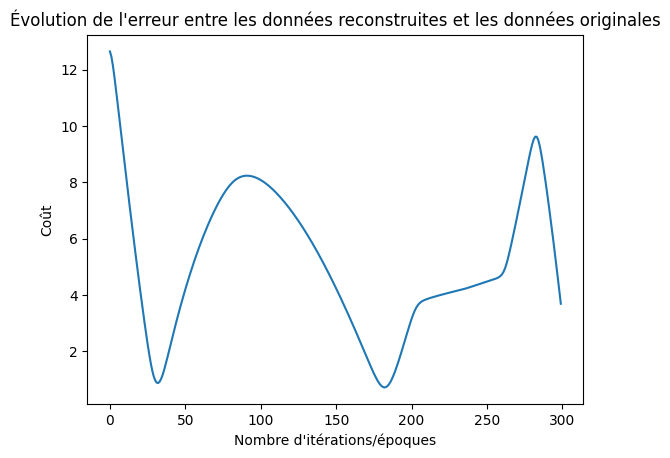

In [64]:
plt.plot(range(num_epochs), loss_history)
plt.xlabel("Nombre d'itérations/époques")
plt.ylabel("Coût")
plt.title("Évolution de l'erreur entre les données reconstruites et les données originales")
plt.show()

In [65]:
print(f"Coût minimum observé : {np.min(loss_history)}")

Coût minimum observé : 0.7149332733097167
